<a href="https://colab.research.google.com/github/bulentsoykan/IDS6938-Computational-Optimization-Models-and-Methods/blob/main/Intro_to_LP_and_IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style='color:#0d9dd6;'>|</span> Linear Programming


Linear programming (LP), also called **linear optimization**, is a method to achieve the best outcome (such as maximum profit or lowest cost) in a mathematical model whose requirements are reprsented by linear relationships.

In this notebook I will a introduction into linear programming with an easy example using the Age of Empires II dataset.
Before we load our date set and do the necessary pre-processing we briefly talk about our goal.

Let's say we are playing a round of Age of Empires II, we choose a civilization and we are in mid game. We have a certain number of resources such as gold, wood, stone, etc. and buildings with which to train the military.

No matter what tactics we choose, what troops we build, the computer beats us every time with its troop strength. What can we do about it?

No cheating is not an option. However, we could use our resources optimally to produce the greatest possible attack strength with our troops. We want to maximize something. How can we achieve that? Exactly, through <b>linear programming</b>.

Please note, this is a small example. There are other criteria that play a role in the optimal troop selection. For example, the attack range or the reload speed plays a not too subordinate role.

Without further do, let´s start.

## <span style='color:#0d9dd6;'>|</span> ⚙️ Setup

In [6]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", color_codes=True, font_scale=1.3)

In [7]:
!wget https://raw.githubusercontent.com/bulentsoykan/IDS6938-Computational-Optimization-Models-and-Methods/main/data/units.csv

--2024-05-29 17:36:25--  https://raw.githubusercontent.com/bulentsoykan/IDS6938-Computational-Optimization-Models-and-Methods/main/data/units.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20997 (21K) [text/plain]
Saving to: ‘units.csv.1’

units.csv.1         100%[===================>]  20.50K  --.-KB/s    in 0.001s  

2024-05-29 17:36:25 (27.7 MB/s) - ‘units.csv.1’ saved [20997/20997]



In [8]:
# We are only interested in the units.csv dataset
units = pd.read_csv('/content/units.csv')

## <span style='color:#0d9dd6;'>|</span> 🛠️ Preprocessing I

In [9]:
units.columns = units.columns.str.strip() # Remove leading and trailing whitespaces in column names
units.cost = units.cost.str.replace(';', ',') # Convert string into valid dict format
units['cost'] = units['cost'].apply(ast.literal_eval) # Convert string to dict

In [10]:
units.head()

,name,description,expansion,age,created_in,cost,build_time,reload_time,attack_delay,movement_rate,line_of_sight,hit_points,range,attack,armor,attack_bonus,armor_bonus,search_radius,accuracy,blast_radius
0,Archer,Quick and light. Weak at close range; excels ...,Age of Kings,Feudal,Archery Range,"{'Wood': 25, 'Gold': 45}",35,2.0,0.35,0.96,6,4,30,4,0/0,NaN,NaN,NaN,80%,NaN
1,Crossbowman,Upgraded archer,Age of Kings,Castle,Archery Range,"{'Wood': 25, 'Gold': 45}",27,2.0,0.35,0.96,7,35,5,5,0/0,+3 spearmen,NaN,NaN,85%,NaN
2,Arbalest,Upgraded crossbowman,Age of Kings,Imperial,Archery Range,"{'Wood': 25, 'Gold': 45}",27,2.0,0.35,0.96,7,40,5,6,0/0,+3 spearmen,NaN,NaN,90%,NaN
3,Cavalry Archer,Fast with ranged attack. Ideal for hit-and-run...,Age of Kings,Castle,Archery Range,"{'Wood': 40, 'Gold': 70}",34,2.0,1.00,1.40,5,50,4,6,0/0,+2 spearmen,NaN,6.0,50%,NaN
4,Heavy Cavalry Archer,Upgraded Cavalry Archer,Age of Kings,Imperial,Archery Range,"{'Wood': 40, 'Gold': 70}",27,2.0,1.00,1.40,6,60,4,7,1/0,+2 spearmen,NaN,NaN,50%,NaN


The ressources are stored as a dictionary in the **cost** column. We have to extract those dict and create separate columns.

In [11]:
unique_keys = set().union(*units['cost'].apply(dict.keys))
for key in unique_keys:
    units[key] = units['cost'].apply(lambda x: x.get(key))

Now we do some cleaning. We do not need all columns and we have to handle **NaN** values.

In [12]:
units = units.fillna(0)

In [13]:
# List all columns
units.columns

Index(['name', 'description', 'expansion', 'age', 'created_in', 'cost',
       'build_time', 'reload_time', 'attack_delay', 'movement_rate',
       'line_of_sight', 'hit_points', 'range', 'attack', 'armor',
       'attack_bonus', 'armor_bonus', 'search_radius', 'accuracy',
       'blast_radius', 'Provides', 'Food', 'Gold', 'info', 'Cost', 'Wood'],
      dtype='object')

In [14]:
# Get only relevant columns
units = units[['name', 'expansion', 'age', 'created_in', 'attack', 'hit_points', 'Wood', 'Gold', 'Food']]

In [15]:
data = units.copy()

## <span style='color:#0d9dd6;'>|</span>  📊 EDA

I want to understand the data a bit. So we have to do a bit of EDA to get familiar with the data.

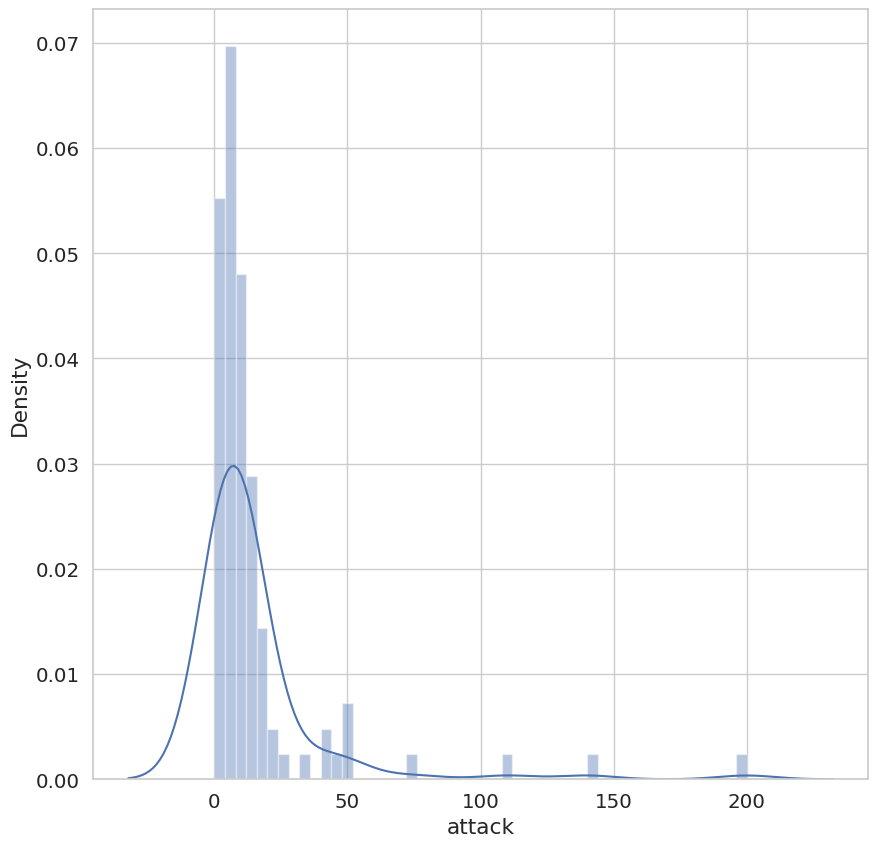

In [16]:
fig = plt.figure(figsize=(10, 10))
sns.distplot(data['attack'])
plt.show();

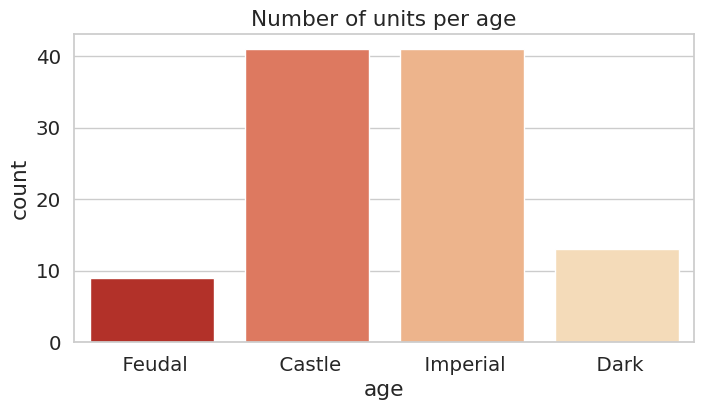

In [17]:
plt.figure(figsize=(8, 4))
sns.countplot(x=data['age'], palette='OrRd_r').set_title('Number of units per age')
plt.show();

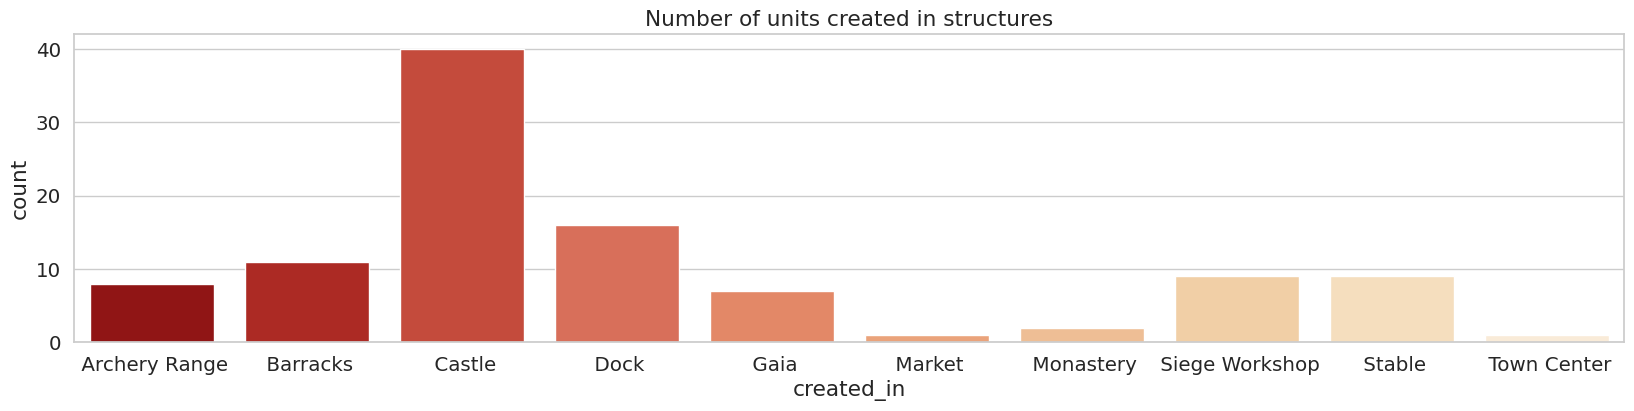

In [18]:
plt.figure(figsize=(20, 4))
sns.countplot(x=data['created_in'], palette='OrRd_r').set_title('Number of units created in structures')
plt.show();

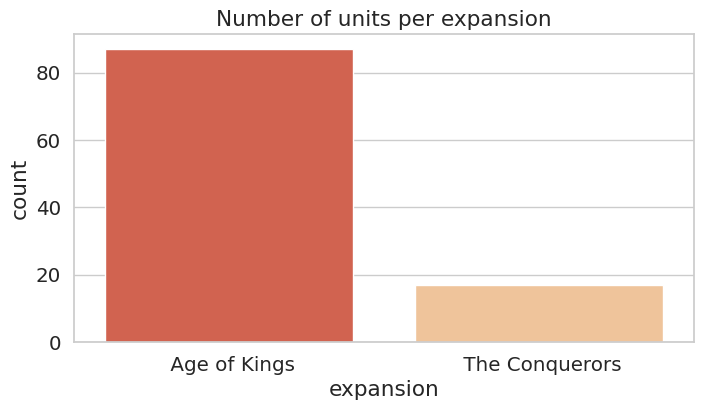

In [19]:
plt.figure(figsize=(8, 4))
sns.countplot(x=data['expansion'], palette='OrRd_r').set_title('Number of units per expansion')
plt.show();

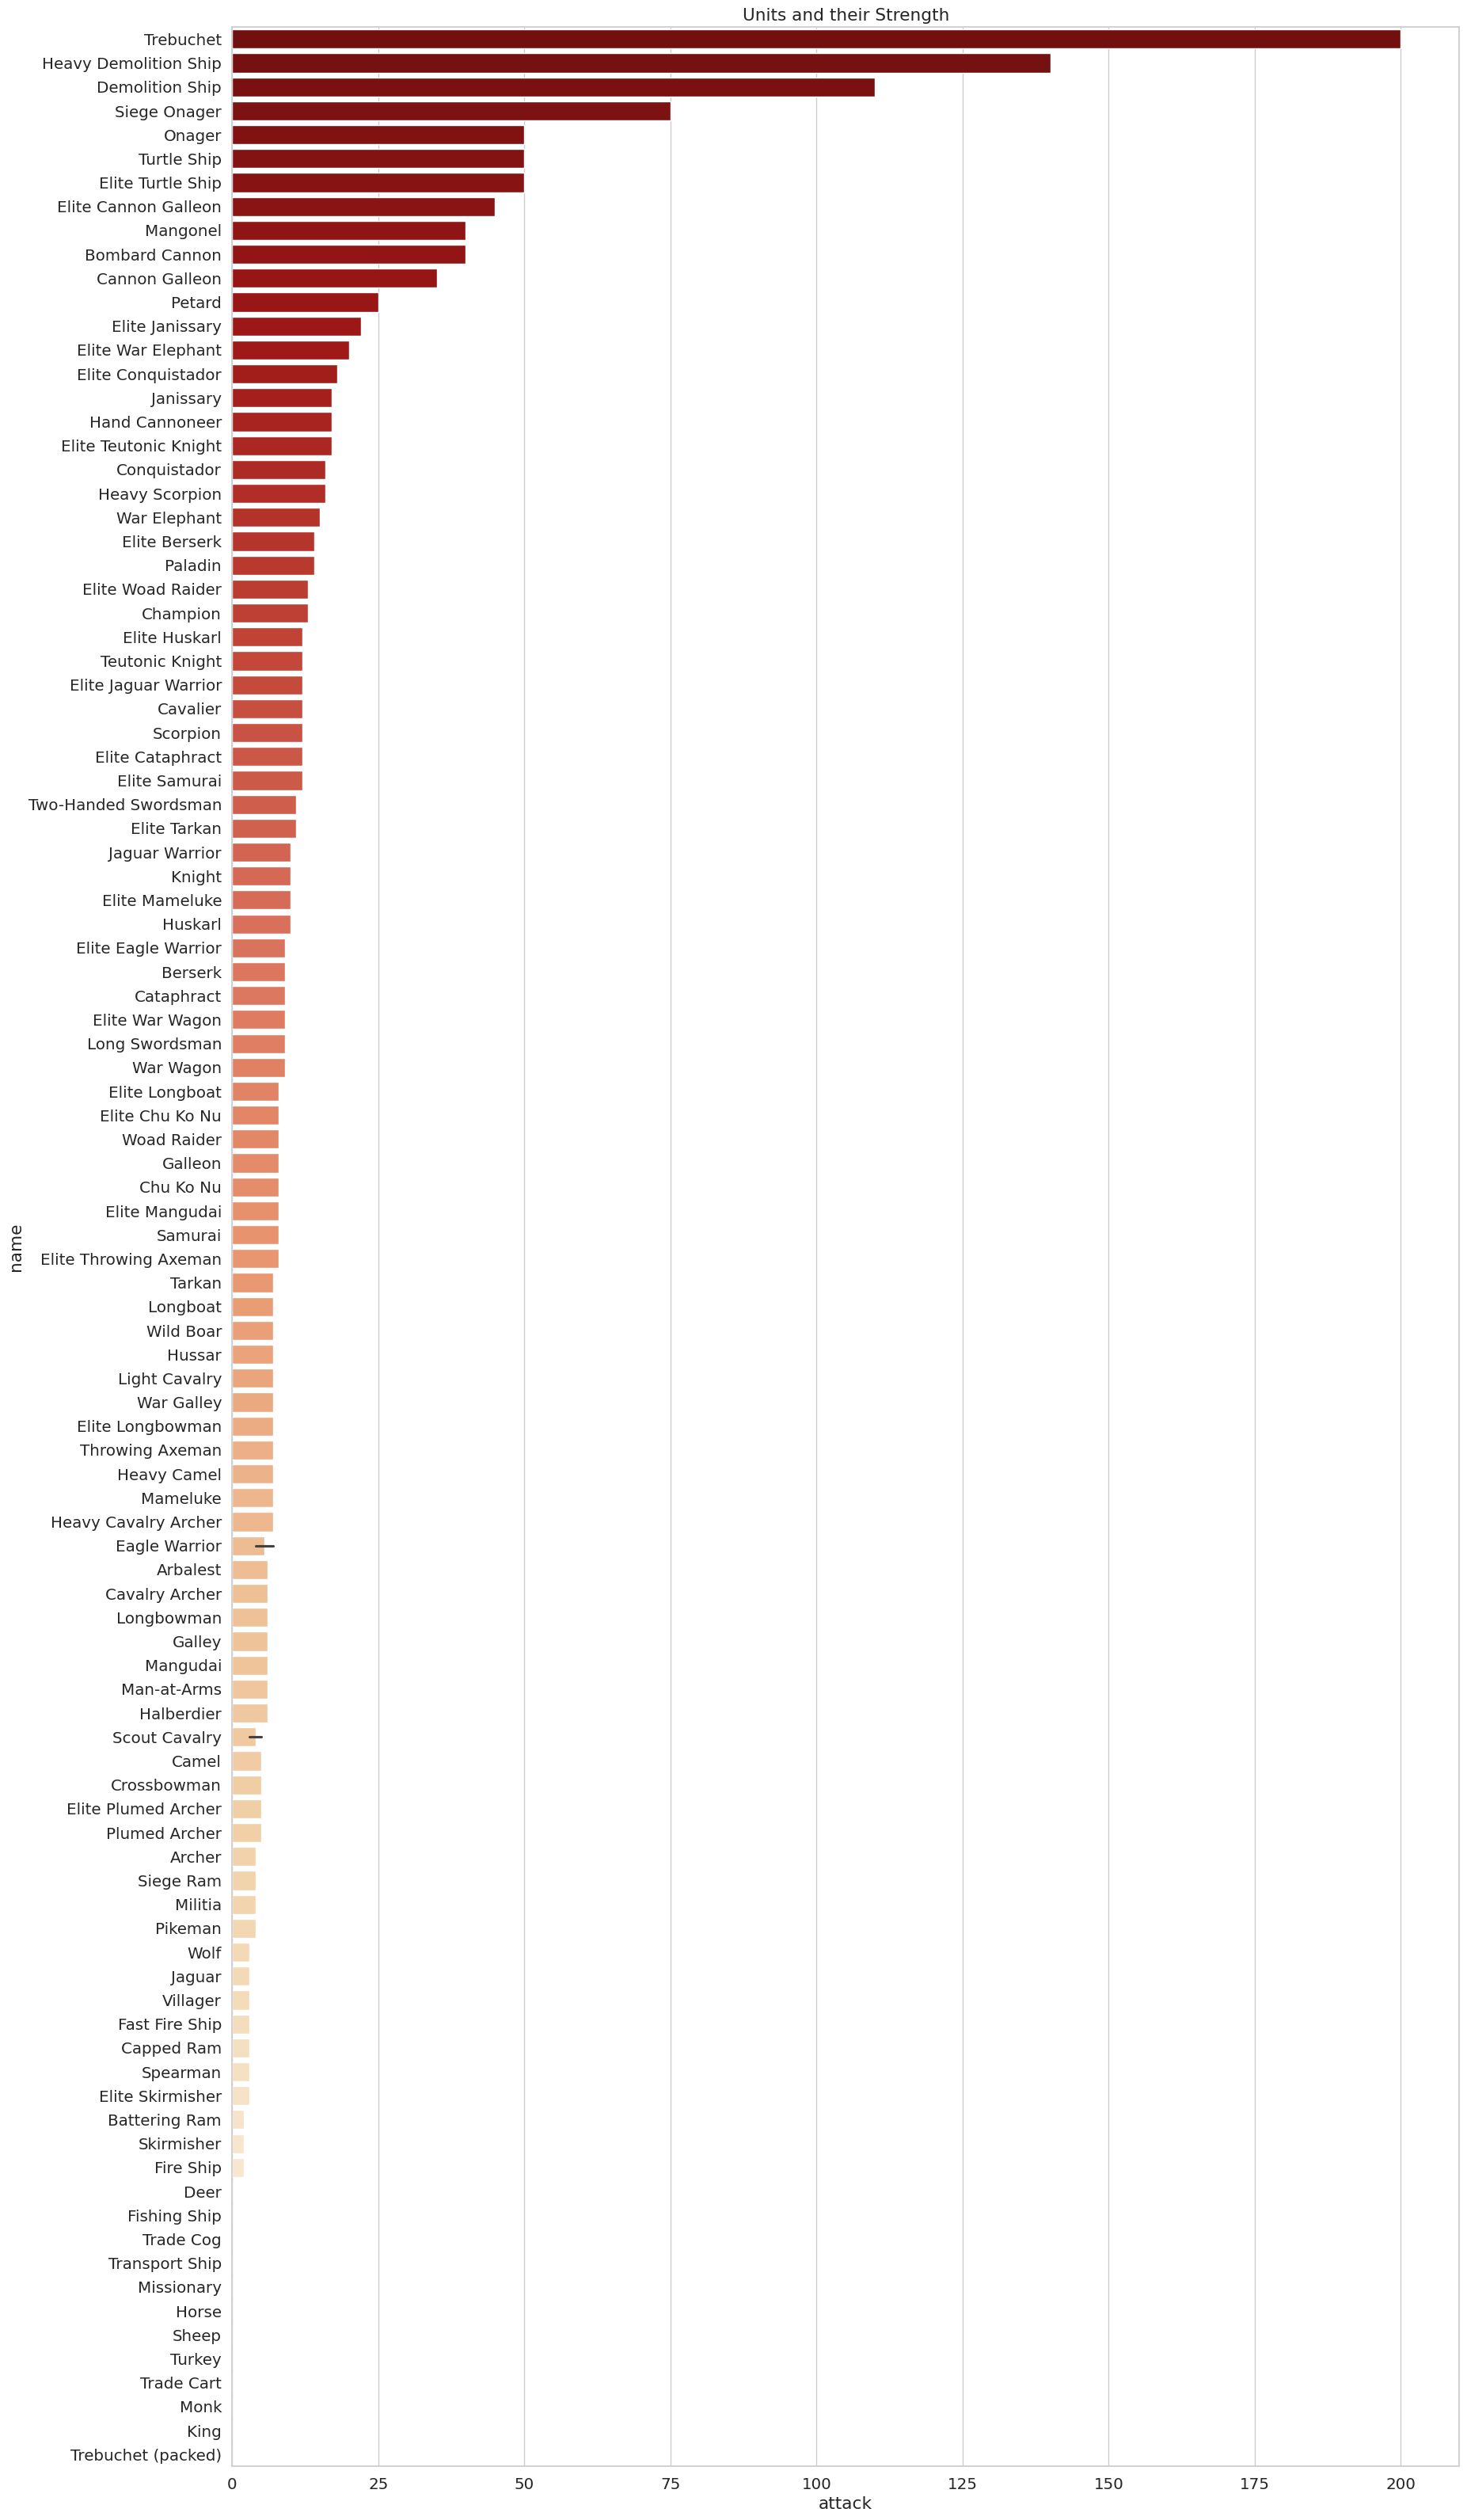

In [20]:
data = data.sort_values(by='attack', ascending=False)
plt.figure(figsize=(20, 40))
sns.barplot(data=data,
           x=data.attack,
           y=data.name,
           palette='OrRd_r'
            ).set_title('Units and their Strength')
plt.show();

In [21]:
data

,name,expansion,age,created_in,attack,hit_points,Wood,Gold,Food
21,Trebuchet,Age of Kings,Imperial,Castle,200,150,200.0,200.0,0.0
26,Heavy Demolition Ship,Age of Kings,Imperial,Dock,140,60,70.0,50.0,0.0
25,Demolition Ship,Age of Kings,Castle,Dock,110,50,70.0,50.0,0.0
52,Siege Onager,Age of Kings,Imperial,Siege Workshop,75,70,160.0,135.0,0.0
51,Onager,Age of Kings,Imperial,Siege Workshop,50,60,160.0,135.0,0.0
...,...,...,...,...,...,...,...,...,...
43,Turkey,The Conquerors,Dark,Gaia,0,7,0.0,0.0,0.0
46,Trade Cart,Age of Kings,Feudal,Market,0,70,100.0,50.0,0.0
48,Monk,Age of Kings,Castle,Monastery,0,30,0.0,100.0,0.0
19,King,Age of Kings,Dark,Castle,0,75,0.0,0.0,50.0


**Summary**
- We will only use units from the base game (exclude conquerors pack)
- We will only use units created in `barracks`, `archery range` and
- We will stick to one age, let´s use `feudal`

## <span style='color:#0d9dd6;'>|</span> 🛠️ Preprocessing II

We fixed the problem, there the column names had leading whitespaces. We also have that problem for the column values itselfs:

In [22]:
print(data['created_in'].values)

[' Castle' ' Dock' ' Dock' ' Siege Workshop' ' Siege Workshop' ' Dock'
 ' Dock' ' Dock' ' Siege Workshop' ' Siege Workshop' ' Dock' ' Castle'
 ' Castle' ' Castle' ' Castle' ' Castle' ' Archery Range' ' Castle'
 ' Castle' ' Siege Workshop' ' Castle' ' Castle' ' Stable' ' Castle'
 ' Barracks' ' Castle' ' Castle' ' Castle' ' Stable' ' Siege Workshop'
 ' Castle' ' Castle' ' Barracks' ' Castle' ' Castle' ' Stable' ' Castle'
 ' Castle' ' Barracks' ' Castle' ' Castle' ' Castle' ' Barracks' ' Castle'
 ' Dock' ' Castle' ' Castle' ' Dock' ' Castle' ' Castle' ' Castle'
 ' Castle' ' Castle' ' Dock' ' Gaia' ' Stable' ' Stable' ' Dock' ' Castle'
 ' Castle' ' Stable' ' Castle' ' Archery Range' ' Barracks'
 ' Archery Range' ' Archery Range' ' Castle' ' Dock' ' Castle' ' Barracks'
 ' Barracks' ' Stable' ' Stable' ' Archery Range' ' Castle' ' Castle'
 ' Archery Range' ' Barracks' ' Siege Workshop' ' Barracks' ' Barracks'
 ' Gaia' ' Gaia' ' Town Center' ' Dock' ' Siege Workshop' ' Barracks'
 ' Stable' ' 

Let´s quickly fix that for the column values too.

In [23]:
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [24]:
df = data[data['expansion'] == 'Age of Kings']
df = df[df['created_in'].isin(['Barracks', 'Archery Range', 'Stable'])]
df = df[df['age'] == 'Feudal']
df = df.reset_index(drop=True)

Finally after applying all filters our unit data looks like that:

In [25]:
df

,name,expansion,age,created_in,attack,hit_points,Wood,Gold,Food
0,Man-at-Arms,Age of Kings,Feudal,Barracks,6,45,0.0,20.0,60.0
1,Scout Cavalry,Age of Kings,Feudal,Stable,5,45,0.0,0.0,80.0
2,Archer,Age of Kings,Feudal,Archery Range,4,4,25.0,45.0,0.0
3,Spearman,Age of Kings,Feudal,Barracks,3,45,15.0,0.0,35.0
4,Skirmisher,Age of Kings,Feudal,Archery Range,2,30,35.0,0.0,25.0


## <span style='color:#0d9dd6;'>|</span> 🧠 Solver

Several free Python libraries are specialized to interact with linear or mixed-integer-linear programming solvers:
- [SciPy Optimization and Root Finding](https://docs.scipy.org/doc/scipy/reference/optimize.html)
- [PuLP](https://www.coin-or.org/PuLP/solvers.html)
- [Pyomo](https://pyomo.readthedocs.io/en/stable/solving_pyomo_models.html#supported-solvers)
- [CVXOPT](https://cvxopt.org/userguide/coneprog.html#optional-solvers)

In this tutorial i will use [Google OR-Tools](https://developers.google.com/optimization?hl=de), which is quite user friendly.

In [ ]:
!pip install -qq ortools

In [28]:
# Import QR-tool wrapper
from ortools.linear_solver import pywraplp

In [29]:
solver = pywraplp.Solver('Mazimize unit power', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

## <span style='color:#0d9dd6;'>|</span> 🧮 Variables

The first thing we need are the variables we want to optimize. <br>
We have 5 units. So we have to define 5 variables. We are looking for round numbers of units, so I will use `IntVar`.

In [30]:
man_at_arms = solver.IntVar(0, solver.infinity(), 'man_at_arms')
scout_cavalry = solver.IntVar(0, solver.infinity(), 'scout_cavalry')
archer = solver.IntVar(0, solver.infinity(), 'archer')
spearman = solver.IntVar(0, solver.infinity(), 'spearman')
skirmisher = solver.IntVar(0, solver.infinity(), 'skirmisher')

## <span style='color:#0d9dd6;'>|</span> ⛓️ Constraints

We have a limited number of resources we can use to produce the units. In other words, **we can´t spend more resources than we have**. <br>
**Our resources are:**<br>
🌾 1000 Food<br>
🪵 1200 Wood<br>
💰  800 Gold<br>

According to the table, units have the following costs:

| Unit          | Food | Wood | Gold |
|---------------|------|------|------|
| Man-at-Arms   | 60   | 0    | 20   |
| Scout Cavalry | 80   | 0    | 0    |
| Archer        | 0    | 25   | 45   |
| Spearman      | 35   | 15   | 0    |
| Skirmisher    | 25   | 35   | 0    |


We can write one constraint per resource as follows:

$$60 * ManAtArms + 80 * ScoutCavalry + 0 * Archer + 35 * Spearman + 25 * Skirmisher \leq 1000$$

$$0 * ManAtArms + 0 * ScoutCavalry + 25 * Archer + 15 * Spearman + 35 * Skirmisher \leq 1200$$

$$20 * ManAtArms + 0 * ScoutCavalry + 45 * Archer + 0 * Spearman + 0 * Skirmisher \leq 800$$

In [31]:
solver.Add(60 * man_at_arms + 80 * scout_cavalry + 0 * archer + 35 * spearman + 25 * skirmisher <= 1000)
solver.Add(0 * man_at_arms + 0 * scout_cavalry + 25 * archer + 15 * spearman + 35 * skirmisher <= 1200)
solver.Add(20 * man_at_arms + 0 * scout_cavalry + 45 * archer + 0 * spearman + 0 * skirmisher <= 800)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x78693f809050> >

## <span style='color:#0d9dd6;'>|</span> 🎯 Objective

We defined our variables and constraints, the final step is to define our objective. <br>
In linear programming, this function has to be **linear**, so of the form `ax + by + cz + d`. We want to recruit the army with the highest power.

**Man at Arms:** 💪 6 <br>
**Scout Cavalry:** 💪 5 <br>
**Archer:** 💪 4 <br>
**Spearman:** 💪 3 <br>
**Skirmisher:** 💪 2 <br>

$$max 6 * ManAtArms + 5 * ScoutCavalry + 4 * Archer + 3 * Spearman + 2 * Skirmisher$$

In [32]:
solver.Maximize(man_at_arms * 6 + scout_cavalry * 5 + archer * 4 + spearman * 3 + skirmisher * 2)

## <span style='color:#0d9dd6;'>|</span> 🏆 Optimize

In [33]:
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print('Solution')
    print(f'Solved in {solver.wall_time():.2f} milliseconds in {solver.iterations()} iterations')
    print()
    print('Army:')
    print(f' - Man at Arms = {man_at_arms.solution_value()}')
    print(f' - Scout Cavalry = {scout_cavalry.solution_value()}')
    print(f' - Archer = {archer.solution_value()}')
    print(f' - Spearman = {spearman.solution_value()}')
    print(f' - Skirmisher = {skirmisher.solution_value()}')
    print()
    print(f'Optimal power = {solver.Objective().Value()} 💪 power')

Solution
Solved in 44.00 milliseconds in 2 iterations

Army:
 - Man at Arms = 0.0
 - Scout Cavalry = 0.0
 - Archer = 17.77777777777778
 - Spearman = 28.571428571428577
 - Skirmisher = 0.0

Optimal power = 156.82539682539684 💪 power


**Note:** We declared our variables as `IntVar` but got a float result. This is due to GLOP doesn´t handle integers.

## <span style='color:#0d9dd6;'>|</span> 📃 Conclusion

Any linear optimization problem can be solved using the following 5 steps:

1) **Choose a solver**: I chooses GLOP <br>
2) **Declare variables**: The parameter to optimize, the different units <br>
3) **Delcare constraints**: Each of the units has costs. The total cost cound not exceed the limited resources <br>
4) **Define objective**: I want the maximum unit power - opposite would be minimize <br>
5) **Optimizing**: GLOP found an optimal solution extremly fast <br>

# <span style='color:#0d9dd6;'>|</span> Integer Programming
## <span style='color:#0d9dd6;'>|</span> Introduction

**A short recap:**<br>
In the section above we got a optimal unit with non-integer values, although we defined the variables as `IntVar`. The problem here is not the model but the choice of the solver.


*What excactly is the problem?*


GLOP is a pure linear progrmaming solver. In linear programming, the decision variables can take on any real number within a specified range, including non-integer values (fractions, decimals, etc.). The objective function and constraints remain linear, but the variables are continuous, meaning they can be fractional or decimal.
For example, if you have a linear programming problem to optimize the production quantities of different products, the solution might suggest producing 5.5 units of Product A and 3.25 units of Product B, which are non-integer values.


In **integer programming** (IP), the decision variables are restricted to taking on only integer values (i.e., whole numbers). This restriction introduces additional complexity to the optimization problem since it means you are looking for a solution among discrete points rather than considering the entire continuous space.


**Mixed-integer programming** (MIP) is a generalization that combines both continuous (non-integer) and integer variables in the optimization problem. This means that some decision variables can take fractional values (like in LP), while others must be integers (like in IP). MIP problems are more challenging to solve than LP or IP individually because they combine the complexity of both.


## <span style='color:#0d9dd6;'>|</span> 📊 Choosing the right Solver
Other solvers like SCIP or CBC can solve both **MIP** and **MINLP** (mixed integer nonlinear programming) problems. In Google OR-Tools we can use the same model and just change the solver to SCIP or CBC.

In [34]:
# Create a solver with CBC
solver = pywraplp.Solver('Mazimize unit power', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
# Create variables we want to maximize
man_at_arms = solver.IntVar(0, solver.infinity(), 'man_at_arms')
scout_cavalry = solver.IntVar(0, solver.infinity(), 'scout_cavalry')
archer = solver.IntVar(0, solver.infinity(), 'archer')
spearman = solver.IntVar(0, solver.infinity(), 'spearman')
skirmisher = solver.IntVar(0, solver.infinity(), 'skirmisher')
# Add constraints for resources
solver.Add(60 * man_at_arms + 80 * scout_cavalry + 0 * archer + 35 * spearman + 25 * skirmisher <= 1000)
solver.Add(0 * man_at_arms + 0 * scout_cavalry + 25 * archer + 15 * spearman + 35 * skirmisher <= 1200)
solver.Add(20 * man_at_arms + 0 * scout_cavalry + 45 * archer + 0 * spearman + 0 * skirmisher <= 800)
# Maximize the objective function
solver.Maximize(man_at_arms * 6 + scout_cavalry * 5 + archer * 4 + spearman * 3 + skirmisher * 2)
# If optimal solution was found, print the results
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print('Solution')
    print(f'Solved in {solver.wall_time():.2f} milliseconds in {solver.iterations()} iterations')
    print()
    print('Army:')
    print(f' - Man at Arms = {man_at_arms.solution_value()}')
    print(f' - Scout Cavalry = {scout_cavalry.solution_value()}')
    print(f' - Archer = {archer.solution_value()}')
    print(f' - Spearman = {spearman.solution_value()}')
    print(f' - Skirmisher = {skirmisher.solution_value()}')
    print()
    print(f'Optimal power = {solver.Objective().Value()} 💪 power')

Solution
Solved in 33.00 milliseconds in 157 iterations

Army:
 - Man at Arms = 1.0
 - Scout Cavalry = 0.0
 - Archer = 17.0
 - Spearman = 24.0
 - Skirmisher = 4.0

Optimal power = 154.0 💪 power


As you can see our units are now discrete. In this example, we would generally just round the values since the rror is insignificant.

Just a quick reminder to choose an appropiate solver:

- **LP** for continuous variables
- **MIP/MILP** for a combination of continous and discrete variables.

## <span style='color:#0d9dd6;'>|</span> 📦 A more general Model
In the example above we hard coded all of our variables and constraints. What if our resources changes? We have to update all of our variables one by one.

Of course there is a much more better approach. We can store our parameters in objects like **arrays** or **dicts**.

In [35]:
# Arrays to store parameters
# Data matrix: Each index for one unit, containing values for food, wood, gold, attack
units_arr = ['Man at Arms', 'Scout Cavalry', 'Archer', 'Spearman', 'Skirmisher']
resources_arr = [1000, 1200, 800]
data_arr = [[60, 0, 20, 6],
        [80, 0, 0, 5],
        [0, 25, 45, 4],
        [35, 15, 0, 3],
        [25, 35, 0, 2]
       ]

In [36]:
def solve(units, data, resources):
    solver = pywraplp.Solver('Maximize army power', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    units = [solver.IntVar(0, solver.infinity(), unit) for unit in units]

    for r, _ in enumerate(resources):
        solver.Add(sum(data[u][r] * units[u] for u, _ in enumerate(units)) <= resources[r])

    solver.Maximize(sum(data[u][-1] * units[u] for u, _ in enumerate(units)))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        print('================= Solution =================')
        print(f'Solved in {solver.wall_time():.2f} milliseconds in {solver.iterations()} iterations')
        print()
        print(f'Optimal value = {solver.Objective().Value()} 💪power')
        print('Army:')
        for u, _ in enumerate(units):
            print(f' - {units[u].name()} = {units[u].solution_value()}')
    else:
        print('The solver could not find an optimal solution.')

In [37]:
solve(units_arr, data_arr, resources_arr)

================= Solution =================
Solved in 21.00 milliseconds in 157 iterations

Optimal value = 154.0 💪power
Army:
 - Man at Arms = 1.0
 - Scout Cavalry = 0.0
 - Archer = 17.0
 - Spearman = 24.0
 - Skirmisher = 4.0


We got exactly the same results. Cool right? 😎

## <span style='color:#0d9dd6;'>|</span> 💡 A more complex Model
Image we have much more resources, are in a modern age and are not restrictured to any structures. We can produce a lot more different units. This will definitively increase our overall unit power.

Let´s get all units which are available in the Imperial age. I will exclude all units created in castle and dock. Elite units from different civilizations are build in castle, also we do not know if we can build the dock because some maps do not have sea in their environment. Finally we do not want units from the siege workshop because they are only useful against buildings.

In [38]:
# Filter data
imps = data[data['age'] == 'Imperial']
imps = imps[~data['created_in'].isin(['Castle', 'Dock', 'Siege Workshop'])].reset_index(drop=True)

Our unit table looks like that:

In [39]:
imps

,name,expansion,age,created_in,attack,hit_points,Wood,Gold,Food
0,Hand Cannoneer,Age of Kings,Imperial,Archery Range,17,35,0.0,50.0,45.0
1,Paladin,Age of Kings,Imperial,Stable,14,160,0.0,75.0,60.0
2,Champion,Age of Kings,Imperial,Barracks,13,70,0.0,20.0,60.0
3,Cavalier,Age of Kings,Imperial,Stable,12,120,0.0,75.0,60.0
4,Two-Handed Swordsman,Age of Kings,Imperial,Barracks,11,60,0.0,20.0,60.0
5,Elite Eagle Warrior,The Conquerors,Imperial,Barracks,9,60,0.0,50.0,20.0
6,Hussar,The Conquerors,Imperial,Stable,7,75,0.0,0.0,80.0
7,Heavy Camel,Age of Kings,Imperial,Stable,7,120,0.0,60.0,55.0
8,Heavy Cavalry Archer,Age of Kings,Imperial,Archery Range,7,60,40.0,70.0,0.0
9,Arbalest,Age of Kings,Imperial,Archery Range,6,40,25.0,45.0,0.0


In this example we will use not only use`attack` as a parameter, we will introduce `hit_points` (health). Health values are higher than attack values, which is why we want to add a weighting factor to make them more comparable.

Lets take 10 as an example:

$$power = 10 * attack + hitPoints$$

So our objective function becomes:

$$maximize \sum_{u \epsilon units}^{} (10 * attack + hitPoints) \cdot u$$

Adapting our code to this new problem is actually quite simple. We just have to change the input parameters and update the objective function.

In [40]:
units_arr = imps['name'].values.tolist()
resources_arr = [18900, 16520, 9000]
data_arr = []

for index, row in imps.iterrows():
    data_arr.append([row['Food'], row['Wood'], row['Gold'], row['attack'], row['hit_points']])

print('Parameters:')
print(f'Units: {units_arr}')
print()
print(f'Resources: {resources_arr}')
print()
print(f'Data:{data_arr}')

Parameters:
Units: ['Hand Cannoneer', 'Paladin', 'Champion', 'Cavalier', 'Two-Handed Swordsman', 'Elite Eagle Warrior', 'Hussar', 'Heavy Camel', 'Heavy Cavalry Archer', 'Arbalest', 'Halberdier']

Resources: [18900, 16520, 9000]

Data:[[45.0, 0.0, 50.0, 17, 35], [60.0, 0.0, 75.0, 14, 160], [60.0, 0.0, 20.0, 13, 70], [60.0, 0.0, 75.0, 12, 120], [60.0, 0.0, 20.0, 11, 60], [20.0, 0.0, 50.0, 9, 60], [80.0, 0.0, 0.0, 7, 75], [55.0, 0.0, 60.0, 7, 120], [0.0, 40.0, 70.0, 7, 60], [0.0, 25.0, 45.0, 6, 40], [35.0, 25.0, 0.0, 6, 60]]


In [41]:
def solve_army(UNITS, DATA, RESOURCES):
    solver = pywraplp.Solver('Maximize army power', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    units = [solver.IntVar(0, solver.infinity(), unit) for unit in UNITS]
    for r, _ in enumerate(RESOURCES):
        solver.Add(sum(DATA[u][r] * units[u] for u, _ in enumerate(units)) <= RESOURCES[r])
    solver.Maximize(sum((10*DATA[u][-2] + DATA[u][-1]) * units[u] for u, _ in enumerate(units)))
    status = solver.Solve()
    status
    if status == pywraplp.Solver.OPTIMAL:
        print('================= Solution =================')
        print(f'Solved in {solver.wall_time():.2f} milliseconds in {solver.iterations()} iterations')
        print()
        print(f'Optimal value = {solver.Objective().Value()} 💪power')
        print('Army:')
        for u, _ in enumerate(units):
            print(f' - {units[u].name()} = {units[u].solution_value()}')
    else:
        print('The solver could not find an optimal solution.')

In [42]:
solve(units_arr, data_arr, resources_arr)

================= Solution =================
Solved in 44.00 milliseconds in 384 iterations

Optimal value = 40160.0 💪power
Army:
 - Hand Cannoneer = 0.0
 - Paladin = 23.0
 - Champion = 0.0
 - Cavalier = 0.0
 - Two-Handed Swordsman = 0.0
 - Elite Eagle Warrior = 1.0
 - Hussar = 0.0
 - Heavy Camel = 0.0
 - Heavy Cavalry Archer = 1.0
 - Arbalest = 159.0
 - Halberdier = 500.0


It took only 40 milliseconds to find the optimal solution.

## <span style='color:#0d9dd6;'>|</span> ⛓️ Combining constraints

You will start the game with a scout. The scout can be used to remove fog from the map and reveal the enemy. Imagine you count every unit the enemy has and calculate this current strength. We could build a better army, but our resources are precious and it wouldn´t be very efficient. All we have to do is to build a better army with a power higher than the enemies power. For example if the CPU has a total power of **10000** we just need a power of **10001** to defeat his army.

In other words, the total power is not a constraint:
$$power >= 10000$$
instead of the objective to maximize. However we have a new goal. We want to **minimize** the resources we need to build the optimal army.

For formally we want a constraint that says *the sum of the power of the selected units must be strictly greather than 10000*
$$\sum_{u \epsilon units}^{} (10 * attack + hitPoints) \cdot u > 10000$$

And our objective function should *minimize the sum of resources to spent*
$$minimize \sum_{u \epsilon units}^{} (food + wood + gold) \cdot u$$

In [43]:
def minimize_resources(UNITS, DATA, RESOURCES, TO_BEAT):
    # Create the linear solver using the CBC backend
    solver = pywraplp.Solver('Minimize resource consumption', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    # Create the variables we want to optimize
    units = [solver.IntVar(0, solver.infinity(), unit) for unit in UNITS]

    # Add constraints for each resource
    for r, _ in enumerate(RESOURCES):
        solver.Add(sum((10 * DATA[u][-2] + DATA[u][-1]) * units[u] for u, _ in enumerate(units)) >= TO_BEAT)

    # Old constraints for limited resources
    for r, _ in enumerate(RESOURCES):
        solver.Add(sum(DATA[u][r] * units[u] for u, _ in enumerate(units)) <= RESOURCES[r])

    # Minimize the objective function
    solver.Minimize(sum((DATA[u][0] + DATA[u][1] + DATA[u][2]) * units[u] for u, _ in enumerate(units)))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('================= Solution =================')
        print(f'Solved in {solver.wall_time():.2f} milliseconds in {solver.iterations()} iterations')
        print()

        power = sum((10 * DATA[u][-2] + DATA[u][-1]) * units[u].solution_value() for u, _ in enumerate(units))
        print(f'Optimal value = {solver.Objective().Value()} 🌾 🪵 💰 resources')
        print(f'Power = 💪{power}')
        print('Army:')
        for u, _ in enumerate(units):
            print(f' - {units[u].name()} = {units[u].solution_value()}')
        print()

        food = sum((DATA[u][0]) * units[u].solution_value() for u, _ in enumerate(units))
        wood = sum((DATA[u][1]) * units[u].solution_value() for u, _ in enumerate(units))
        gold = sum((DATA[u][2]) * units[u].solution_value() for u, _ in enumerate(units))
        print('Resources:')
        print(f' - 🌾 Food = {food}')
        print(f' - 🪵 Wood = {wood}')
        print(f' - 💰 Gold = {gold}')
    else:
          print('The solver could not find an optimal solution.')


In [44]:
minimize_resources(units_arr, data_arr, resources_arr, 10001)

================= Solution =================
Solved in 7.00 milliseconds in 6 iterations

Optimal value = 4015.0 🌾 🪵 💰 resources
Power = 💪10005.0
Army:
 - Hand Cannoneer = 1.0
 - Paladin = 0.0
 - Champion = 49.0
 - Cavalier = 0.0
 - Two-Handed Swordsman = 0.0
 - Elite Eagle Warrior = 0.0
 - Hussar = 0.0
 - Heavy Camel = 0.0
 - Heavy Cavalry Archer = 0.0
 - Arbalest = 0.0
 - Halberdier = 0.0

Resources:
 - 🌾 Food = 2985.0
 - 🪵 Wood = 0.0
 - 💰 Gold = 1030.0


We found the optimal solution. We just have to recruit 49 champions to achieve a total power of 10005 which is greather than the enemy power. This will cost us 2985 foodl and just 1030 gold.

## <span style='color:#0d9dd6;'>|</span> 📃 Conclusion

We learned from this section:

- We have to carefully select the right solver and type of optimization problem (LP, MIP, NLP)
- We can create generalized models
- We can add as much constraints and variables we want (this will increase the time to solve the problem)